In [1]:
#Class declaration for ENO class

#INPUT : CSV file designated by location and year

#OUTPUTS: Harvested Energy (henergy)
#         Forecast (fcast)
#         Time (year, day, hr)
#         Place (location)
#         Flags (end_of_day, end_of_year)

#METHODS: To shuffle days randomly (shuffle_days())
#         To emulate days of only a certain daytype (daytype(x))

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [3]:
np.random.seed(230228)

In [4]:
class ENO(object):
    
    #no. of forecast types is 6 ranging from 0 to 5
  
    def __init__(self, location='tokyo', year=2010, shuffle=False):
        self.location = location
        self.year = year
        self.day = None
        self.hr = None
        
        self.shuffle = shuffle

        self.TIME_STEPS = None #no. of time steps in one episode
        self.NO_OF_DAYS = None #no. of days in one year
        
        self.senergy = None #matrix with harvested energy data for the entire year
        self.fforecast = None #matrix with forecast values for each day
        

        self.henergy = None #harvested energy variable
        self.fcast = None #forecast variable
        self.sorted_days = [] #days sorted according to day type
    
    #function to get the solar data for the given location and year and prep it
    def get_data(self):
        #CSV files contain the values of GSR (Global Solar Radiation in MegaJoules per meters squared per hour)
        file = './' + self.location +'/' + str(self.year) + '.csv'
        #skiprows=4 to remove unnecessary title texts
        #usecols=4 to read only the Global Solar Radiation (GSR) values
        solar_radiation = pd.read_csv(file, skiprows=4, encoding='shift_jisx0213', usecols=[4])
        
        #convert dataframe to numpy array
        solar_radiation = solar_radiation.values
        #GSR values (in MJ/sq.mts) need to be expressed in mWhr per hour
        # Conversion is accomplished by GSR * size of solar cell * efficiency of solar cell * to be filled later.....
        solar_energy = np.array([i *0.0165*1000000*0.15*1000/(60*60) for i in solar_radiation])
        
        #reshape solar_energy into no_of_daysx24 array
        senergy = solar_energy.reshape(-1,24)
        senergy[np.isnan(senergy)] = 0 #convert missing data in CSV files to zero
        
        if(self.shuffle): #if class instatiation calls for shuffling the day order. Required when learning
            np.random.shuffle(senergy) 
        
        self.senergy = senergy
        return 0
    
    #function to map total day energy into type of day ranging from 0 to 5
    #the classification into day types is quite arbitrary. There is no solid logic behind this type of classification.
    def get_day_state(self,tot_day_energy):
        if (tot_day_energy < 2500):
            day_state = 0
        elif (2500 <= tot_day_energy < 5000):
            day_state = 1
        elif (5000 <= tot_day_energy < 8000):
            day_state = 2
        elif (8000 <= tot_day_energy < 10000):
            day_state = 3
        elif (10000 <= tot_day_energy < 12000):
            day_state = 4
        else:
            day_state = 5
        return int(day_state)
    
    
    def get_forecast(self):
        #create a perfect forecaster.
        tot_day_energy = np.sum(self.senergy, axis=1) #contains total energy harvested on each day
        get_day_state = np.vectorize(self.get_day_state)
        self.fforecast = get_day_state(tot_day_energy)
        
        #sort days depending on the type of day and shuffle them; maybe required when learning
        for fcast in range(0,6):
            fcast_days = ([i for i,x in enumerate(self.fforecast) if x == fcast])
            np.random.shuffle(fcast_days)
            self.sorted_days.append(fcast_days)
        return 0
    
    def reset(self,day=0): #it is possible to reset to the beginning of a certain day
        
        self.get_data() #first get data for the given year
        self.get_forecast() #calculate the forecast
        
        self.TIME_STEPS = self.senergy.shape[1]
        self.NO_OF_DAYS = self.senergy.shape[0]
        
        self.day = day
        self.hr = 0
        
        self.henergy = self.senergy[self.day][self.hr]
        self.fcast = self.fforecast[self.day]
        
        end_of_day = False
        end_of_year = False
        return [self.henergy, self.fcast, end_of_day, end_of_year]

    
    def step(self):
        end_of_day = False
        end_of_year = False

        if(self.hr < self.TIME_STEPS - 1):
            self.hr += 1
            self.henergy = self.senergy[self.day][self.hr] 
        else:
            if(self.day < self.NO_OF_DAYS -1):
                end_of_day = True
                self.hr = 0
                self.day += 1
                self.henergy = self.senergy[self.day][self.hr] 
                self.fcast = self.fforecast[self.day]
            else:
                end_of_day = True
                end_of_year = True
        
        return [self.henergy, self.fcast, end_of_day, end_of_year]

In [5]:
class ENO_daytype(object):
    
    #no. of forecast types is 6 ranging from 0 to 5
  
    def __init__(self, location='tokyo', year=2010, shuffle=False, daytype=0):
        self.location = location
        self.year = year
        self.day = None
        self.hr = None
        
        self.shuffle = shuffle
        self.daytype = daytype

        self.TIME_STEPS = None #no. of time steps in one episode
        self.NO_OF_DAYS = None #no. of days in one year
        
        self.senergy = None #matrix with harvested energy data for the entire year
        self.fforecast = None #matrix with forecast values for each day
        

        self.henergy = None #harvested energy variable
        self.fcast = None #forecast variable
        self.sorted_days = [] #days sorted according to day type
        
        self.no_of_fcast_days = None #no. of days of a particular daytype
        self.daycount = None #index for the days of specific daytype
    
    #function to get the solar data for the given location and year and prep it
    def get_data(self):
        #CSV files contain the values of GSR (Global Solar Radiation in MegaJoules per meters squared per hour)
        file = './' + self.location +'/' + str(self.year) + '.csv'
        #skiprows=4 to remove unnecessary title texts
        #usecols=4 to read only the Global Solar Radiation (GSR) values
        solar_radiation = pd.read_csv(file, skiprows=4, encoding='shift_jisx0213', usecols=[4])
        
        #convert dataframe to numpy array
        solar_radiation = solar_radiation.values
        #GSR values (in MJ/sq.mts) need to be expressed in mWhr per hour
        # Conversion is accomplished by GSR * size of solar cell * efficiency of solar cell * to be filled later.....
        solar_energy = np.array([i *0.0165*1000000*0.15*1000/(60*60) for i in solar_radiation])
        
        #reshape solar_energy into no_of_daysx24 array
        senergy = solar_energy.reshape(-1,24)
        senergy[np.isnan(senergy)] = 0 #convert missing data in CSV files to zero
        
        if(self.shuffle): #if class instatiation calls for shuffling the day order. Required when learning
            np.random.shuffle(senergy) 
        
        self.senergy = senergy
        return 0
    
    #function to map total day energy into type of day ranging from 0 to 5
    #the classification into day types is quite arbitrary. There is no solid logic behind this type of classification.
    def get_day_state(self,tot_day_energy):
        if (tot_day_energy < 2500):
            day_state = 0
        elif (2500 <= tot_day_energy < 5000):
            day_state = 1
        elif (5000 <= tot_day_energy < 8000):
            day_state = 2
        elif (8000 <= tot_day_energy < 10000):
            day_state = 3
        elif (10000 <= tot_day_energy < 12000):
            day_state = 4
        else:
            day_state = 5
        return int(day_state)
    
    
    def get_forecast(self):
        #create a perfect forecaster.
        tot_day_energy = np.sum(self.senergy, axis=1) #contains total energy harvested on each day
        get_day_state = np.vectorize(self.get_day_state)
        self.fforecast = get_day_state(tot_day_energy)
        
        #sort days depending on the type of day and shuffle them; maybe required when learning
        for fcast in range(0,6):
            fcast_days = ([i for i,x in enumerate(self.fforecast) if x == fcast])
            np.random.shuffle(fcast_days)
            self.sorted_days.append(fcast_days)
        return 0
    
    def reset(self): #it is possible to reset to the beginning of a certain day
        
        self.get_data() #first get data for the given year
        self.get_forecast() #calculate the forecast
        
        self.TIME_STEPS = self.senergy.shape[1]
        self.NO_OF_DAYS = self.senergy.shape[0]
        
        self.daycount = 0
        self.day = self.sorted_days[self.daytype][self.daycount]
        self.no_of_fcast_days = len(self.sorted_days[self.daytype])
        self.hr = 0
        
        self.henergy = self.senergy[self.day][self.hr]
        self.fcast = self.fforecast[self.day]
        
        end_of_day = False
        end_of_year = False
        return [self.henergy, self.fcast, end_of_day, end_of_year]

    
    def step(self):
        end_of_day = False
        end_of_year = False
        

        if(self.hr < self.TIME_STEPS - 1):
            self.hr += 1
            self.henergy = self.senergy[self.day][self.hr] 
        else:
            if(self.daycount < self.no_of_fcast_days -1):
                end_of_day = True
                self.hr = 0
                self.daycount += 1
                self.day = self.sorted_days[self.daytype][self.daycount]
                self.henergy = self.senergy[self.day][self.hr] 
                self.fcast = self.fforecast[self.day]
            else:
                self.daycount = 0
                end_of_day = True
                end_of_year = True
        
        return [self.henergy, self.fcast, end_of_day, end_of_year]

In [6]:
#Discrete Adaptive Power Manager using default ENO class
class DAPM (object):
    def __init__(self,location='tokyo', year=2010):

        #all energy values i.e. BMIN, BMAX, BOPT, HMAX, DMAX are in mWhr
        
        self.BMIN = 0.0                #Minimum battery level that is tolerated. Maybe non-zero also
        self.BMAX = 20000.0            #Max Battery Level. May not necessarily be equal to total batter capacity
        self.BOPT = 0.6 * self.BMAX    #Optimal Battery Level. Assuming 60% of battery is the optimum
        
        self.HMIN = 0      #Minimum energy that can be harvested by the solar panel.
        self.HMAX = 1000   #Maximum energy that can be harvested by the solar panel.
        
        self.DMAX = 500      #Maximum energy that can be consumed by the node in one time step.
        self.N_ACTIONS = 10  #No. of different duty cycles possible
        self.DMIN = self.DMAX/self.N_ACTIONS #Minimum energy that can be consumed by the node in one time step.
        
        self.batt = None      #battery variable
        self.enp = None       #enp at end of hr
        self.henergy = None   #harvested energy variable
        self.fcast = None     #forecast variable
        
        self.no_of_batt_state = 10;
        self.no_of_enp_state = 42;
        self.no_of_henergy_state = 30;
        self.no_of_day_state = 6;
        
        self.location = location
        self.year = year
        self.eno = ENO(self.location, self.year, shuffle=False)
  
    #FUNCTIONS TO DISCRETIZE STATES FROM NORMALIZED VALUES OF BATTERY, ENP, HENERGY and FORECAST
    def get_batt_state(self,batt):
        batt_state = np.floor(batt*self.no_of_batt_state)
        batt_state = np.clip(batt_state,0,self.no_of_batt_state-1)
        return int(batt_state)
    
    def get_enp_state(self,enp):
        #assuming the battery deviates equally in both enp directions
        #NEEDS TO BE RETHOUGHT AND UPDATED

        enp = np.clip(enp,-0.5,0.5)
        _enp = 0.5 + enp
        enp_state = np.ceil(_enp*self.no_of_enp_state)
        enp_state = np.clip(enp_state, 0, self.no_of_enp_state-1)
        return int(enp_state)
    
    def get_henergy_state(self,henergy):
        henergy_state = int(np.floor(henergy*self.no_of_henergy_state))
        henergy_state = np.clip(henergy_state, 0, self.no_of_henergy_state-1)
        return int(henergy_state)
    
    def get_fcast_state(self,fcast):
        return fcast * (self.no_of_day_state-1)
    
    def discretize(self,c_state):
        s = np.zeros(4)
        s[0] = self.get_batt_state(c_state[0])
        s[1] = self.get_enp_state(c_state[1])
        s[2] = self.get_henergy_state(c_state[2])
        s[3] = self.get_fcast_state(c_state[3])
        return s.astype(int)
    #END OF FUNCTIONS USED FOR DISCRETIZATION
    
    
    def reset(self,day=0,batt=-1):
        henergy, fcast, day_end, year_end = self.eno.reset(day) #reset the eno environment
        if(batt == -1):
            self.batt = self.BOPT
        else:
            self.batt = batt
            
        self.batt = np.clip(self.batt, self.BMIN, self.BMAX)
        self.enp = self.BOPT - self.batt #enp is calculated
        self.henergy = np.clip(henergy, self.HMIN, self.HMAX) #clip henergy within HMIN and HMAX
        self.fcast = fcast
        
        norm_batt = self.batt/self.BMAX
        norm_enp = self.enp/(self.BMAX/2)
        norm_henergy = self.henergy/self.HMAX
        norm_fcast = self.fcast/(self.no_of_day_state-1)

        c_state = [norm_batt, norm_enp, norm_henergy, norm_fcast] #continuous states
        d_state = self.discretize(c_state) #discretized states
        reward = 0
        
        return [d_state, reward, day_end, year_end]
    
    def getstate(self): #query the present state of the system
        norm_batt = self.batt/self.BMAX
        norm_enp = self.enp/(self.BMAX/2)
        norm_henergy = self.henergy/self.HMAX
        norm_fcast = self.fcast/(self.no_of_day_state-1)

        c_state = [norm_batt, norm_enp, norm_henergy, norm_fcast] #continuous states
        d_state = self.discretize(c_state) #discretized states

        return d_state

    #reward function
    def rewardfn(self):
        mu = 0
        sig = 1000
        norm_enp = self.enp/(self.BMAX/2)
        if(np.abs(norm_enp) <= self.DMIN*self.eno.TIME_STEPS/(self.BMAX/2)): # DMIN*self.TIME_STEPS/(BMAX/2) - normalized value of worst case power consumption at min duty cycle
            return ((1./(np.sqrt(2.*np.pi)*sig)*np.exp(-np.power((self.enp - mu)/sig, 2.)/2)) * 1E6)
        else:
            return -100 - 0.05*np.abs(self.enp)
    
    def step(self, action):
        day_end = False
        year_end = False
        reward = 0
        
        action = np.clip(action, 0, self.N_ACTIONS-1) #action values range from (0 to N_ACTIONS-1)
        e_consumed = (action+1)*self.DMAX/self.N_ACTIONS   #energy consumed by the node
        
        self.batt += (self.henergy - e_consumed)
        self.batt = np.clip(self.batt, self.BMIN, self.BMAX) #clip battery values within permitted level
        #code to record all the times battery levels have been exceeded
        self.enp = self.BOPT - self.batt
        
        #proceed to the next time step
        self.henergy, self.fcast, day_end, year_end = self.eno.step()
        if(day_end): #if eno object flags that the day has ended then give reward
            reward = self.rewardfn()
        
        norm_batt = self.batt/self.BMAX
        norm_enp = self.enp/(self.BMAX/2)
        norm_henergy = self.henergy/self.HMAX
        norm_fcast = self.fcast/5

        c_state = [norm_batt, norm_enp, norm_henergy, norm_fcast] #continuous states
        d_state = self.discretize(c_state) #discretized states
        return [d_state, reward, day_end, year_end]

In [7]:
#Continuous Adaptive Power Manager using default ENO class
class CAPM (object):
    def __init__(self,location='tokyo', year=2010):

        #all energy values i.e. BMIN, BMAX, BOPT, HMAX, DMAX are in mWhr
        
        self.BMIN = 0.0                #Minimum battery level that is tolerated. Maybe non-zero also
        self.BMAX = 20000.0            #Max Battery Level. May not necessarily be equal to total batter capacity
        self.BOPT = 0.6 * self.BMAX    #Optimal Battery Level. Assuming 60% of battery is the optimum
        
        self.HMIN = 0      #Minimum energy that can be harvested by the solar panel.
        self.HMAX = 1000   #Maximum energy that can be harvested by the solar panel.
        
        self.DMAX = 500      #Maximum energy that can be consumed by the node in one time step.
        self.N_ACTIONS = 10  #No. of different duty cycles possible
        self.DMIN = self.DMAX/self.N_ACTIONS #Minimum energy that can be consumed by the node in one time step.
        
        self.batt = None      #battery variable
        self.enp = None       #enp at end of hr
        self.henergy = None   #harvested energy variable
        self.fcast = None     #forecast variable
        
        self.location = location
        self.year = year
        self.eno = ENO(self.location, self.year, shuffle=False)
  
    
    
    def reset(self,day=0,batt=-1):
        henergy, fcast, day_end, year_end = self.eno.reset(day) #reset the eno environment
        if(batt == -1):
            self.batt = self.BOPT
        else:
            self.batt = batt
            
        self.batt = np.clip(self.batt, self.BMIN, self.BMAX)
        self.enp = self.BOPT - self.batt #enp is calculated
        self.henergy = np.clip(henergy, self.HMIN, self.HMAX) #clip henergy within HMIN and HMAX
        self.fcast = fcast
        
        norm_batt = self.batt/self.BMAX
        norm_enp = self.enp/(self.BMAX/2)
        norm_henergy = self.henergy/self.HMAX
        norm_fcast = self.fcast/(self.no_of_day_state-1)

        c_state = [norm_batt, norm_enp, norm_henergy, norm_fcast] #continuous states
        reward = 0
        
        return [c_state, reward, day_end, year_end]
    
    def getstate(self): #query the present state of the system
        norm_batt = self.batt/self.BMAX
        norm_enp = self.enp/(self.BMAX/2)
        norm_henergy = self.henergy/self.HMAX
        norm_fcast = self.fcast/(self.no_of_day_state-1)
        c_state = [norm_batt, norm_enp, norm_henergy, norm_fcast] #continuous states

        return c_state

    #reward function
    def rewardfn(self):
        mu = 0
        sig = 1000
        norm_enp = self.enp/(self.BMAX/2)
        if(np.abs(norm_enp) <= self.DMIN*self.eno.TIME_STEPS/(self.BMAX/2)): # DMIN*self.TIME_STEPS/(BMAX/2) - normalized value of worst case power consumption at min duty cycle
            return ((1./(np.sqrt(2.*np.pi)*sig)*np.exp(-np.power((self.enp - mu)/sig, 2.)/2)) * 1E6)
        else:
            return -100 - 0.05*np.abs(self.enp)
    
    def step(self, action):
        day_end = False
        year_end = False
        reward = 0
        
        action = np.clip(action, 0, self.N_ACTIONS-1) #action values range from (0 to N_ACTIONS-1)
        e_consumed = (action+1)*self.DMAX/self.N_ACTIONS   #energy consumed by the node
        
        self.batt += (self.henergy - e_consumed)
        self.batt = np.clip(self.batt, self.BMIN, self.BMAX) #clip battery values within permitted level
        #code to record all the times battery levels have been exceeded
        self.enp = self.BOPT - self.batt
        
        #proceed to the next time step
        self.henergy, self.fcast, day_end, year_end = self.eno.step()
        if(day_end): #if eno object flags that the day has ended then give reward
            reward = self.rewardfn()
        
        norm_batt = self.batt/self.BMAX
        norm_enp = self.enp/(self.BMAX/2)
        norm_henergy = self.henergy/self.HMAX
        norm_fcast = self.fcast/5

        c_state = [norm_batt, norm_enp, norm_henergy, norm_fcast] #continuous states
        return [c_state, reward, day_end, year_end]

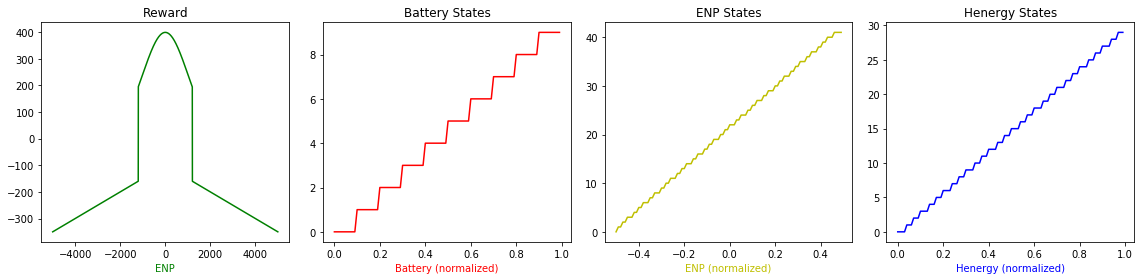

In [8]:
#Check Discrete Adaptive Power Manager Class
pm = DAPM('tokyo',2010) #use data for Tokyo, 2010
pm.reset(day=0, batt=-1) #reset to the first day with BOPT values

#Check reward function
#ENP varies from -0.5 to 0.5
y1 = np.empty(1)
for x in np.arange(-5000,5000):
    pm.enp = x
    y1 = np.append(y1,pm.rewardfn())
y1 = np.delete(y1, 0, 0) #remove the first row which is garbage

#Check state discretiziation functions
#Battery value varies from 0 to 1
y2 = np.empty(1)
for x in np.arange(0,1,0.01):
    temp = pm.get_batt_state(x)
    y2 = np.append(y2,temp)
y2 = np.delete(y2, 0, 0) #remove the first row which is garbage

#Check state discretiziation functions
#ENP value varies from -0.5 to 0.5
#Inconsistent with the reward function 
y3 = np.empty(1)
for x in np.arange(-0.5,0.5,0.01):
    temp = pm.get_enp_state(x)
    y3 = np.append(y3,temp)
y3 = np.delete(y3, 0, 0) #remove the first row which is garbage

#Check state discretiziation functions
#henergy value varies from 0 to 1
y4 = np.empty(1)
for x in np.arange(0,1,0.01):
    temp = pm.get_henergy_state(x)
    y4 = np.append(y4,temp)
y4 = np.delete(y4, 0, 0) #remove the first row which is garbage


####################################
##   PRINT FIGURES##################
fig = plt.figure(figsize=(16,4))

ax1 = fig.add_subplot(1,4,1)
ax1.set_title("Reward")
ax1.set_xlabel("ENP",color='g')
ax1.plot(np.arange(-5000,5000),y1,'g')

ax2 = fig.add_subplot(1,4,2)
ax2.set_title("Battery States")
ax2.set_xlabel("Battery (normalized)",color='r')
ax2.plot(np.arange(0,1,0.01),y2,'r')

ax3 = fig.add_subplot(1,4,3)
ax3.set_title("ENP States")
ax3.set_xlabel("ENP (normalized)",color='y')
ax3.plot(np.arange(-0.5,0.5,0.01),y3,'y')

ax4 = fig.add_subplot(1,4,4)
ax4.set_title("Henergy States")
ax4.set_xlabel("Henergy (normalized)",color='b')
ax4.plot(np.arange(0,1,0.01),y4,'b')

fig.tight_layout()
plt.show()

In [9]:
pm = DAPM('tokyo',2010) #use data for Tokyo, 2010
pm.reset(day=364, batt=-1) #reset to the first day with BOPT values

[array([ 6, 21,  0,  2]), 0, False, False]

In [43]:
print(pm.step(0))
print("Batt = ", pm.batt)
pm.enp
print("ENP = ", pm.enp)
pm.henergy
print("Henergy = ", pm.henergy)

[array([8, 0, 0, 2]), -399.3125, True, True]
Batt =  17986.25
ENP =  -5986.25
Henergy =  0.0
